Christian Hubbs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym 
import torch
from torch import nn
import seaborn as sns
import pandas as pd

# Import custom files
from networks import *
from utils.network_utils import *
from utils.algo_utils import *
from dqn_attractor import *
%matplotlib inline

# Background

Attractor networks provide some level of neural plausibility beyond the standard drift-diffusion model
for binary decision making ([Wang 2008](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2710297/)). These nonlinear models represent competing populations of neurons which are working to come to a decision and are easily extendable to $n$ decision paradigms. One of the limitations of these models is their lack of capability to learn from experience. Learning, however, can be addressed through techniques developed in reinforcement learning ([Sutton and Barto 2018](https://drive.google.com/file/d/1xeUDVGWGUUv1-ccUMAZHJLej2C7aAFWY/view)). 

Previous efforts to integrate learning and decision making include [Pederson et al. 2016](https://www.ncbi.nlm.nih.gov/pubmed/27966103) who focused on integrating learning with the drift diffusion model and [Dunovan and Verstynen 2016](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwitu57LovPeAhUr1lkKHW9cAsgQFjAAegQIBxAB&url=https%3A%2F%2Fwww.frontiersin.org%2Farticles%2F10.3389%2Ffnins.2016.00106&usg=AOvVaw1OVlm6Z0LBWt6I1UweF_X9) who introduced the **Believer-Skeptic** model. 

For this project, I propose an algorithm to combine deep Q-learning with attractor networks to simulate the dynamics of decision making in a learning environment and apply it to a popular [OpenAI Gym](https://gym.openai.com/envs/#classic_control) environment.

# Problem

For this project, I chose the Cart-Pole control problem as set forth in [Barto 1983](https://ieeexplore.ieee.org/document/6313077). This is a classic and well-studied problem in control theory and reinforcement learning. The basic objective is to balance a pole that sits on top of a cart for as long as possible.

<img src="https://www.datahubbs.com/wp-content/uploads/2018/04/cart_pole.jpg">

The agent has only two actions to choose from, whether to push the cart left or to push it right with a constant force to prevent the pole from toppling over. If the cart moves too far to one end or the other, then the episode is over because the cart is out of bounds. For each time step where the pole remains upright, the agent receives a reward of +1 and 0 if the pole has fallen or the cart has moved out of bounds.

This problem was selected because it is well studied and computationally light in comparison to many other reinforcement learning problems, meaning it can be simulated quickly and solved with a small neural network. It has little in the way of stochasicity apart from the starting position of the pole which may begin anywhere from slightly left of center to slightly right of center. The problem is considered solved if the RL agent can learn a policy to keep the pole balanced for 200 consecutive steps.

# Model

To accomplish this, I propose an algorithm that incorporates deep Q-learning with LCA decision dynamics called DQNA (Deep Q Network Attractor). The DQN algorithm is similar to that proposed in [Mnih et al. 2015](https://www.nature.com/articles/nature14236), featuring an experience replay buffer and a target network. The experience replay buffer simply provides samples from previous $SARS'$ tuples for the network to use to train in order to break sequential correlation. The target network provides temporary stability by giving Q-value estimates for the next state ($S'$) to compare current predictions to. This target network is then synced periodically with the nominal DQN to improve its estimates whereby it once again serves as a stable measurement point for the DQN during training.

The DQNA model differs from the typical DQN in that the decision is made via a LCA model that the network feeds rather than via an $\epsilon$-greedy or *softmax* output. The LCA output is fed repeatedly by the output of the DQN until a decision is made, which is understood as the largest firing rate between either the Action 0 (left) or Action 1 (right) channels. The DQNA differs from a typical LCA in that it also utilizes noisy input that is added to the state that the model bases its decisions on rather than adding a noisy element to the firing rates themselves. This causes the DQN portion to process the noisy state, pass it through multiple non-linear layers, and then output that result to the LCA. 

As in a normal DQN, the rewards received from the environment are used to calcluate the error and feed the loss function -- here, we use mean-squared error (MSE) for the loss -- which then provides the updates for the weights and biases of the network. Additional parameters are entered into the model through the LCA output, however it is not clear how to update these in a systematic manner or incorporate them into the backpropogation step. As a result, multiple tests are run with different combinations of these values (e.g. $I_0$, $\kappa$, $\beta$, etc.) as well as various DQN hyperparameters which must be chosen upfront. 

## Deep Q-Learning with LCA Decision Dynamics

> Select hyperparameters for background excitation ($I_0$), recurrent feedback strength ($k$), cross-inhibition 
($\beta$), time step ($\Delta t$), noise scale ($\Gamma$), discount factor ($\gamma$), and learning rate ($\alpha$).

> Initialize $Q$ function with random weights $\theta$

> **For all** episodes $n \in N$ **do**

> > Initialize state $s_{0}$

> > **For all** $k \in K$ **do**

> > > **While** $t \leq T_{max}$ **do**

> > > > $I_a = Q \big(s_k + \Gamma \mathcal{N}(\mu, \sigma^2), a, \theta_k \big) \quad \forall a \in A$

> > > > $dr_a = r_{a, t} + \big(I_0 + I_a + kr_{a, t-1} - \beta \sum_{i \in A \setminus a} r_{i, t-1} \big) \Delta t \quad \forall a,i \in A$

> > > **End While**

> > > Select action $a_k = max_a (dr_a)$

> > > Execute action $a_k$, and observe reward $r_k$ and state $s_{k+1}$

> > > **If** $s_{k+1}$ is a terminal state **then**

> > > > $y_k = r_k$

> > > **Else**

> > > > $y_k = r_k + \gamma max_a Q(s_k, \theta_k)$

> > > **End If**

> > > $\mathcal{L}_\theta = \big(y_k - Q(s_k, a_k, \theta_k) \big)^2$

> > > $\theta_{k+1} = \theta_k - \frac{\partial}{\partial \theta} \mathcal{L}_{\theta}$

> > **End For**

> **End For**


# Results

Training the DQN with the LCA output was rather difficult. The results were erratic and, do to the fact that roughly 1,000 forward passes must be run on each step to generate the time dynamics for the LCA, training was slowed immensly. A typical training curve is shown below where the learned policy is essentially on par with a random policy.

![DQNA Training](CartPole-v0/dqn_attractor/20181126_2051/training_plots.png)
$$\text{DQNA Training}$$

To ease the training, I separated the DQN from the LCA and trained it independently to get reasonable weights and biases before using the LCA for the decision making during testing. This trained the DQN in the standard manner, then values for the LCA hyperparameters were selected to test the decision making capabilities of the DQNA.

![DQN Training](CartPole-v0/dqn/20181201_1634/training_plots.png)
$$\text{DQN Training}$$

The network and algorithm settings can be found in the network parameter file: `CartPole-v0/dqn/20181201_1634/parameters.txt`

In [2]:
_parameters = pd.read_csv('CartPole-v0/dqn/20181201_1634/parameters.txt')
_parameters

,parameters,value
0,hl,3
1,hn,16
2,lr,0.003
3,bias,True
4,gpu,cpu
5,actFunc,sigmoid
6,convNet,False
7,env,CartPole-v0
8,gamma,0.99
9,maxEps,5000


Additionally, to train the network, from the command line call: `python run_dqn.py` and pass the parameters from the corresponding arguments above. For example, to run with the default settings but with 10 hidden layers, use:

`python run_dqn.py --hl 10`

In [3]:
parameters = pd.DataFrame(_parameters['value'].values.reshape(1, -1), 
                          columns=_parameters['parameters'])
env = gym.make(parameters['env'][0])
net = QNetwork(env,
               n_hidden_layers=int(parameters['hl'][0]),
               n_hidden_nodes=int(parameters['hn'][0]),
               learning_rate=float(parameters['lr'][0]),
               bias=bool(parameters['bias'][0]), 
               activation_function=parameters['actFunc'][0],
               dqn_algo=parameters['dqnAlgo'][0])

# Load network weights
net.load_state_dict(torch.load('CartPole-v0/dqn/20181201_1634/weights.pt'))

Network
Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=16, out_features=2, bias=True)
)


### Testing DQNA with Noisy Input

With the parameters selected for the DQNA, we can run it for various values of $\Gamma$, which scales the noise from the normally distributed sample. We can also compare this to the output of the trained DQN under the same scenario to gauge the robustness of the DQNA vs. the DQN and vice-versa. Do to the computational load of the DQNA, it is only tested for 10 episodes whereas the DQN is tested for 100.

In [31]:
# With noisy state
noise = [0, 0.01, 0.1, 1, 10, 100]
dqn_eps = 100
dqn_attractor_eps = 10
dqn_results = np.zeros((len(noise), dqn_eps))
dqna_results = np.zeros((len(noise), dqn_attractor_eps))
for i, n in enumerate(noise):
    agent = DQNAttractorAgent(net, noise=n)
    agent.test(n_test_episodes=dqn_eps, attractor=False, noisy_state=True, print_results=False)
    dqn_results[i] = np.array(agent.test_rewards).copy()
    agent.test(n_test_episodes=dqn_attractor_eps, attractor=True, print_results=False)
    dqna_results[i] = np.array(agent.test_rewards).copy()

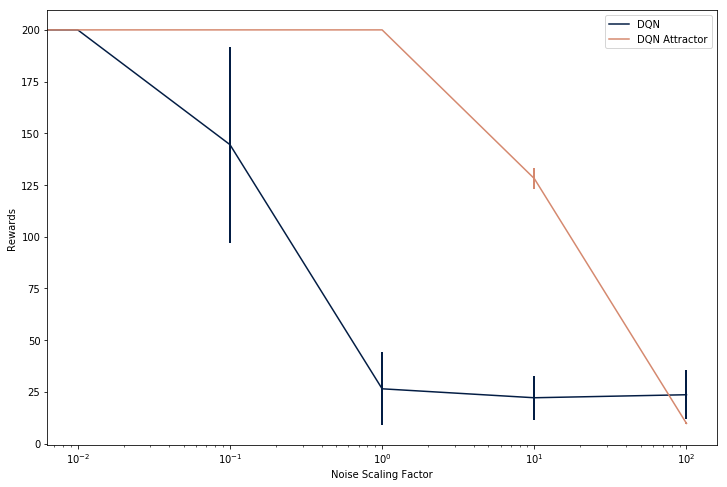

In [35]:
# Plot results
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(noise, dqn_results.mean(axis=1), label='DQN', c='#031d44')
ax.errorbar(noise, dqn_results.mean(axis=1), yerr=dqn_results.std(axis=1),
             color='#031d44', capthick=20, lw=2, ls='none')

ax.plot(noise, dqna_results.mean(axis=1), label='DQN Attractor', c='#d5896f')
ax.errorbar(noise, dqna_results.mean(axis=1), yerr=dqna_results.std(axis=1),
             color='#d5896f', capthick=20, lw=2, ls='none')
plt.semilogx()
plt.legend()
plt.xlabel('Noise Scaling Factor')
plt.ylabel('Rewards')
plt.show()

Interestingly, the DQN with the LCA output (DQNA) outperformed the standard DQN showing that the attractor made the network more robust to noise on the input state. Additionally, the attractor network had less variance than the DQN. This is likely due to the fact that the DQNA sees noise added to the state repeatedly and the error averages out over time. Regardless, it is interesting to see better performance from the DQNA vs the standard DQN although it is much more computationally intensive. 

Additionally, we can see what changes in the background excitation level do the decision quality.

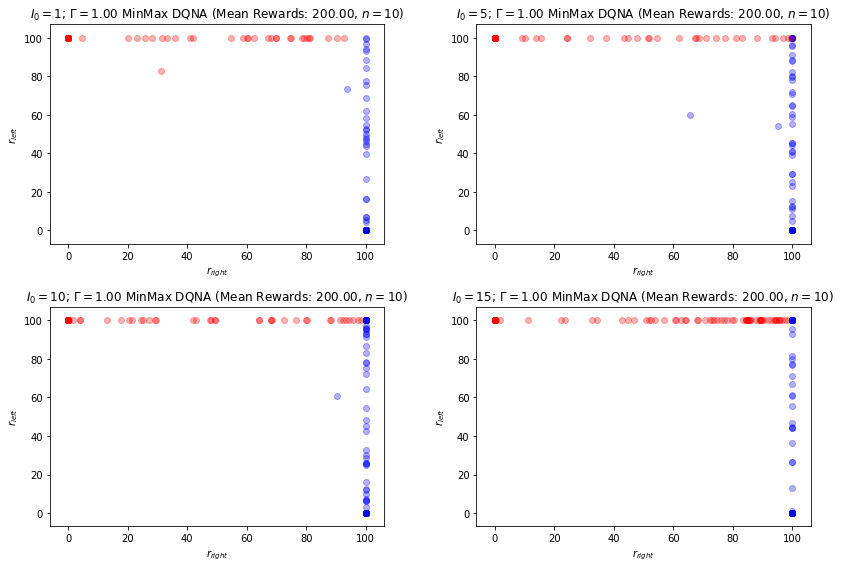

In [53]:
I_0 = [1, 5, 10, 15]
dqn_attractor_eps = 10
noise = 1
dqna_results = np.zeros((len(I_0), dqn_attractor_eps))
fig = plt.figure(figsize=(12,8))
row_lim = int(len(I_0) / 2)
col_lim = 2
grid = plt.GridSpec(row_lim, col_lim)
for i, I0 in enumerate(I_0):
    agent = DQNAttractorAgent(net,
                            I_0=I0,
                            noise=noise)
    agent.test(n_test_episodes=dqn_attractor_eps, minmax=True)
    dqna_results[i] = np.array(agent.test_rewards).copy()
    ax = fig.add_subplot(grid[int(i / row_lim), i%2])
    for traj in agent.test_trajectories:
        deltaV = traj[-1,1] - traj[-1,0]
        r_left = traj[-1,0]
        r_right = traj[-1,1]
        ax.scatter(r_left, r_right, c='r', alpha=0.3) if deltaV > 0 else ax.scatter(
            r_left, r_right, c='b', alpha=0.3)
        ax.set_xlabel(r'$r_{right}$')
        ax.set_ylabel(r'$r_{left}$')
        ax.set_title(r'$I_0=${}; $\Gamma=${:.2f} MinMax DQNA (Mean Rewards: {:.2f}, $n=${})'.format(
            I0, noise, np.mean(agent.test_rewards), dqn_attractor_eps))
plt.tight_layout()
plt.show()

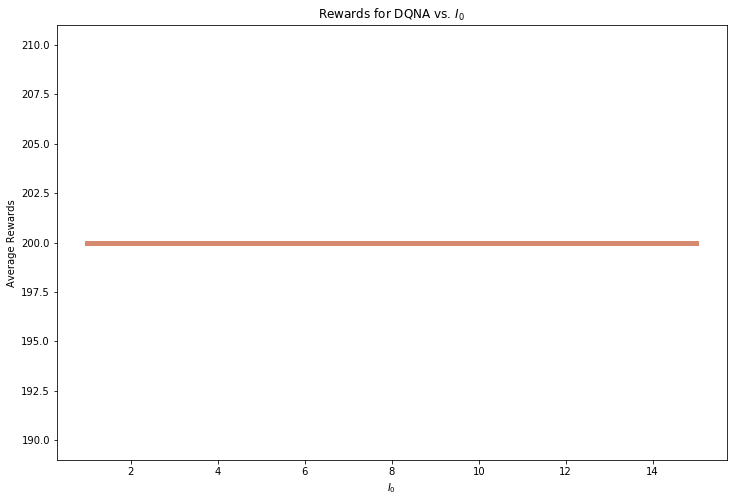

In [57]:
# Plot results
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(I_0, dqna_results.mean(axis=1), label='DQN Attractor', c='#d5896f',
        linewidth=5)
ax.errorbar(I_0, dqna_results.mean(axis=1), yerr=dqna_results.std(axis=1),
             color='#d5896f', capthick=20, lw=2, ls='none')
plt.xlabel(r'$I_0$')
plt.title(r'Rewards for DQNA vs. $I_0$')
plt.ylabel('Average Rewards')
plt.show()

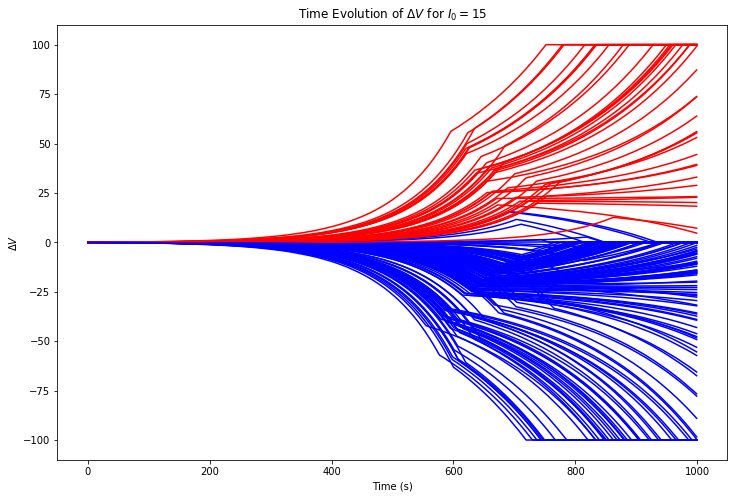

In [60]:
plt.figure(figsize=(12,8))
for traj in agent.test_trajectories:
    deltaV = traj[:,0] - traj[:,1]
    plt.plot(deltaV, c='r', label='left') if deltaV[-1] > 0 else plt.plot(
        deltaV, c='b', label='right')
plt.xlabel('Time ($\mu s$)')
plt.ylabel(r'$\Delta V$')
plt.title(r'Time Evolution of $\Delta V$ for $I_0=${}'.format(agent.I_0))
plt.show()

The test results for various values of $I_0$ show no difference indicating that the algorithm is rather insensitive to differences here.

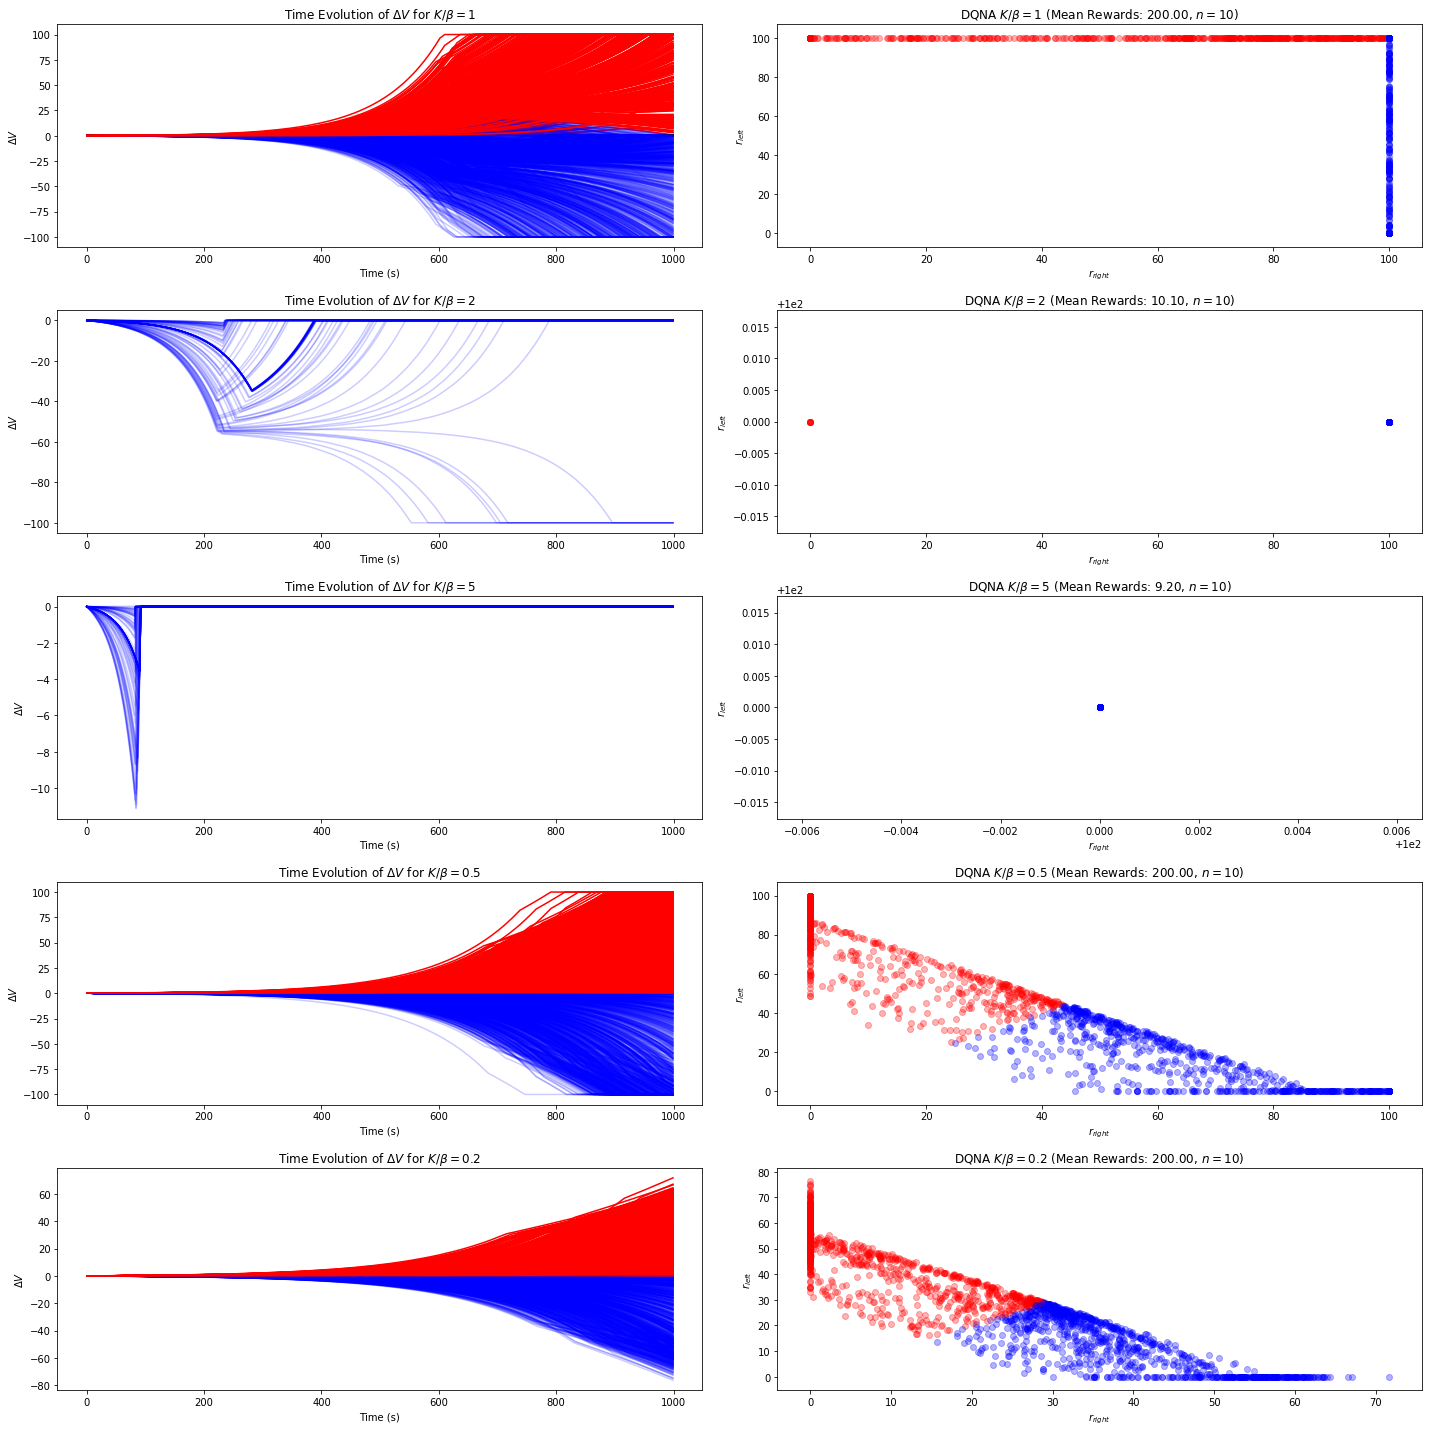

In [73]:
kb_ratio = [1, 2, 5, 0.5, 0.2]
I_0 = 5
dqn_attractor_eps = 10
noise = 1
dqna_results = np.zeros((len(kb_ratio), dqn_attractor_eps))
fig = plt.figure(figsize=(20,20))
row_lim = len(kb_ratio)
col_lim = 2
grid = plt.GridSpec(row_lim, col_lim)
for i, kb in enumerate(kb_ratio):
    # Scale default K by kb
    k = 5 * kb
    agent = DQNAttractorAgent(net,
                            I_0=I0,
                            noise=noise,
                            K=k)
    agent.test(n_test_episodes=dqn_attractor_eps, minmax=True)
    dqna_results[i] = np.array(agent.test_rewards).copy()
    
    # Plot trajectories
    ax = fig.add_subplot(grid[int(i), 0])
    for traj in agent.test_trajectories:
        deltaV = traj[:,0] - traj[:,1]
        plt.plot(deltaV, c='r', label='left') if deltaV[-1] > 0 else plt.plot(
            deltaV, c='b', label='right', alpha=0.2)
        plt.xlabel('Time ($\mu s$)')
        plt.ylabel(r'$\Delta V$')
        plt.title(r'Time Evolution of $\Delta V$ for $K/\beta=${}'.format(kb))
    
    # Plot final points
    ax = fig.add_subplot(grid[int(i), 1])
    for traj in agent.test_trajectories:
        deltaV = traj[-1,1] - traj[-1,0]
        r_left = traj[-1,0]
        r_right = traj[-1,1]
        ax.scatter(r_left, r_right, c='r', alpha=0.3) if deltaV > 0 else ax.scatter(
            r_left, r_right, c='b', alpha=0.3)
        ax.set_xlabel(r'$r_{right}$')
        ax.set_ylabel(r'$r_{left}$')
        ax.set_title(r'DQNA $K/\beta=${} (Mean Rewards: {:.2f}, $n=${})'.format(
            kb, np.mean(agent.test_rewards), dqn_attractor_eps))
plt.tight_layout()
plt.show()

Tweaking the relative strength between the competing channels provided more varied results than other implemented changes or adjustments. 3 of 5 of the values still provided perfect scores of 200 across all trials ($\frac{K}{\beta} = 0.2, 0.5, 1$). I had expected symmetry between 2 and its inverse 0.5, and 5 and its inverse value 0.2 because the relative strength of each of the options is the same. However it seems that the relative strength between the two options and the relative strength with respect to the other parameters (e.g. background excitation) are relevant as well, leading to the asymmetrical results. Regardless, it's surprising to see consistent performance for so many $\frac{K}{\beta}$ ratios. 

# Conclusion

The DQNA proves to be difficult to train as a DQNA, but is trainable with the DQN separated from the attractor network. Some of the largest difficulties with training is the added computational complexity associated with modeling the time dependent decision dynamics and updating the relevant hyperparameters in this more, complex model. Regardless, once the model is trained, it can be tested on the relevant environment and provides good results.

The most striking feature of this model is the consistency of results and the robustness to various hyperparameters of the competing attractor. 